In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb # XGBoost stuff
import numpy as np
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_classif
from ReliefF import ReliefF

In [2]:
root = "../../../"

In [3]:
df = pd.read_csv(root + "datasets/binary/processed/CICDDoS_corr.csv", index_col=[0])

In [4]:
df[' Label'] = df[' Label'].apply(lambda x: 'ATTACK' if x != 'BENIGN' else 'BENIGN')

In [5]:
X = df.drop(columns=[' Label'])
y = df[' Label']

In [6]:
clf_xgb_gain = xgb.XGBClassifier(seed=42)
# clf_xgb.fit(X_train, 
#             y_train,
#             verbose=True,
#             ## the next three arguments set up early stopping.
#             early_stopping_rounds=5,
#             eval_metric='mlogloss',
#             eval_set=[(X_test, y_test)])
clf_xgb_gain.fit(X, y)

C:\Users\pedro\miniconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[23:34:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [7]:
anova = f_classif(X, y)[0]

mi = mutual_info_classif(X, y)

relieff = ReliefF(n_neighbors=20, n_features_to_keep=36)
relieff.fit(X.to_numpy(),y.to_numpy())
relief = relieff.feature_scores

xgb_gain = clf_xgb_gain.feature_importances_

In [8]:
feature_df = pd.DataFrame(columns=["anova", "mi", "relief", "xgb_gain"])
feature_df["anova"] = anova
feature_df["mi"] = mi
feature_df["relief"] = relief
feature_df["xgb_gain"] = xgb_gain
feature_df.index = X.columns

In [9]:
for method in feature_df.columns:
    feature_df[method + '_rank'] = feature_df[method].rank(method='first')

ranks = [column for column in feature_df.columns if 'rank' in column]
feature_df['wrfs'] = feature_df[ranks].sum(axis=1)
feature_df.sort_values(by='wrfs', ascending=False, inplace=True)

In [10]:
feature_df['wrfs']

 Min Packet Length              135.0
 URG Flag Count                 126.0
 Down/Up Ratio                  123.0
 Total Backward Packets         120.0
 Flow Packets/s                 113.0
Init_Win_bytes_forward          113.0
 Fwd Packet Length Max          111.0
Flow Bytes/s                    111.0
 Subflow Bwd Packets             97.0
 Max Packet Length               93.0
Fwd Packets/s                    93.0
 Packet Length Variance          92.0
 Bwd Packet Length Min           89.0
 CWE Flag Count                  87.0
 Init_Win_bytes_backward         85.0
 RST Flag Count                  85.0
Fwd PSH Flags                    83.0
 Flow IAT Std                    80.0
 ACK Flag Count                  80.0
 Total Length of Bwd Packets     80.0
 act_data_pkt_fwd                78.0
 Flow Duration                   77.0
 Bwd Header Length               77.0
 Bwd Packets/s                   77.0
Bwd Packet Length Max            73.0
 Bwd IAT Min                     71.0
 Fwd IAT Std

Text(0, 0.5, 'WRFS')

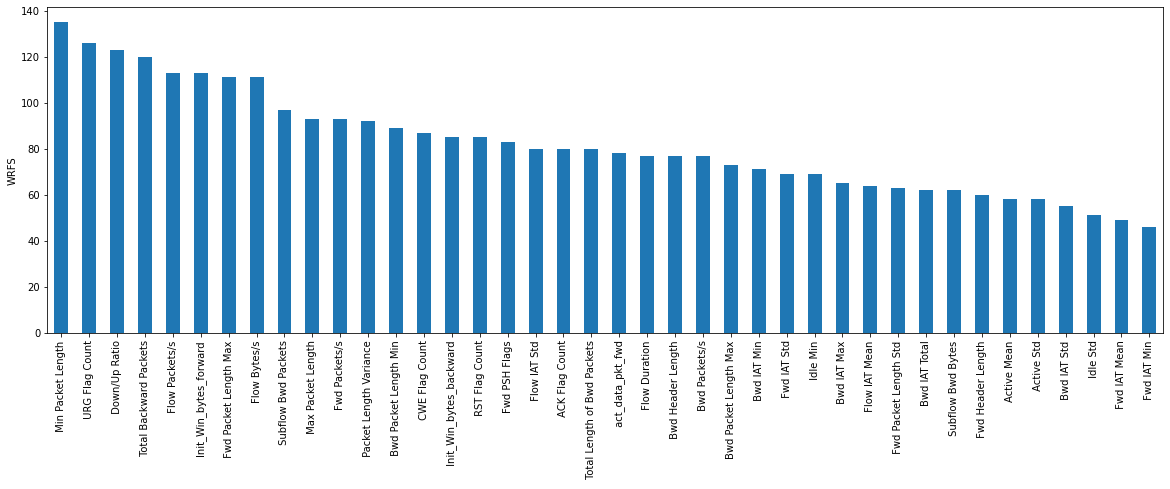

In [11]:
feature_df['wrfs'].plot.bar(figsize=(20, 6))
plt.ylabel('WRFS')

In [12]:
features_to_keep = feature_df.index[:20]
features_to_keep

Index([' Min Packet Length', ' URG Flag Count', ' Down/Up Ratio',
       ' Total Backward Packets', ' Flow Packets/s', 'Init_Win_bytes_forward',
       ' Fwd Packet Length Max', 'Flow Bytes/s', ' Subflow Bwd Packets',
       ' Max Packet Length', 'Fwd Packets/s', ' Packet Length Variance',
       ' Bwd Packet Length Min', ' CWE Flag Count', ' Init_Win_bytes_backward',
       ' RST Flag Count', 'Fwd PSH Flags', ' Flow IAT Std', ' ACK Flag Count',
       ' Total Length of Bwd Packets'],
      dtype='object')

In [13]:
# to remove the rest of the features:
X = X[features_to_keep]

In [14]:
X.shape

(5280, 20)